# EDA del dataset para clasificación de imágenes de retinopatía diabética.

## Avance 1. Análisis exploratorio de datos

### Proyecto Integrador - MNA

### Equipo 21

Integrantes del equipo:
- Guadalupe Esmeralda González Maldonado - A01795767
- Marco Daniel Cameros Bobadilla - A01795655
- Jesús Armando Anaya Orozco - A01795464

Nombre del dataset: DDR2019

Este notebook realiza un análisis exploratorio (EDA) del dataset procesado, orientado a clasificación de imágenes de retinopatía diabética. Los objetivos son:

- **Balance del dataset**: comprobar si las clases están equilibradas o hay desbalance.
- **Clases minoritarias**: identificar qué clases tienen pocos ejemplos y pueden requerir más atención (p. ej. aumento de datos o ponderación de pérdida).
- **Outliers**: detectar imágenes atípicas (brillo/contraste extremos, artefactos).
- **Recomendaciones de aumento de datos**: qué transformaciones aplicar según el desbalance y el dominio (retinopatía diabética).
- **Preprocesado**: evaluar si las imágenes son demasiado oscuras o claras y si conviene normalización/ecualización.

## Información del dataset
- **Formato**: CSV con columnas `filename` y `label`
- **Clases**: 5 clases (0–4) que representan distintos niveles de severidad de DR
- **Etiquetas**: 0: "Normal", 1: "Leve", 2: "Moderada", 3: "Severa", 4: "Proliferativa"

### NOTA:

Dada la naturaleza del proyecto integrador y considerando que tanto el código desarrollado como los datos utilizados son propiedad del patrocinador, no es posible compartir en este momento ni el código fuente completo ni el conjunto de datos asociado. Actualmente, no se cuenta con la autorización del patrocinador para su divulgación. Por esta razón, el presente notebook fue ejecutado en un entorno local en el que se tuvo acceso a dichos recursos durante su desarrollo y análisis. Lo que se comparte a través de este notebook corresponde únicamente a los resultados de su ejecución local, incluyendo las salidas, visualizaciones y análisis solicitados, con el objetivo de documentar y presentar el EDA para su evaluación académica.

In [1]:
# Fijar directorio de trabajo en la raíz del proyecto
import os
from pathlib import Path

_path = Path.cwd()
while _path != _path.parent and not (_path / "pyproject.toml").exists():
    _path = _path.parent
PROJECT_ROOT = _path if (_path / "pyproject.toml").exists() else Path.cwd()
os.chdir(PROJECT_ROOT)

# Librerías para EDA y visualización
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Estilo de gráficos
for style in ("seaborn-v0_8-darkgrid", "seaborn-darkgrid", "ggplot", "default"):
    try:
        plt.style.use(style)
        break
    except (OSError, ValueError):
        continue
sns.set_palette("husl")

# Rutas del dataset
DATA_DIR = PROJECT_ROOT / "data" / "processed" / "ddr2019"
LABELS_CSV = DATA_DIR / "labels.csv"
IMAGES_DIR = DATA_DIR / "images"


In [2]:
# Cargar el dataset (labels)
df = pd.read_csv(LABELS_CSV)

print(f"Forma del dataset: {df.shape}")
print(f"\nNombres de columnas: {list(df.columns)}")
print(f"\nPrimeras filas:")
print(df.head(10))
print(f"\nTipos de datos:")
print(df.dtypes)
print(f"\nInfo básica:")
print(df.info())

Forma del dataset: (12522, 2)

Nombres de columnas: ['filename', 'label']

Primeras filas:
                filename  label
0  20170413102628830.jpg      0
1  20170413111955404.jpg      0
2  20170413112015395.jpg      0
3  20170413112017305.jpg      0
4  20170413112528859.jpg      0
5  20170413112758639.jpg      0
6  20170413112758698.jpg      0
7  20170413113351595.jpg      0
8  20170413113710974.jpg      0
9  20170413114550593.jpg      0

Tipos de datos:
filename    object
label        int64
dtype: object

Info básica:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12522 entries, 0 to 12521
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  12522 non-null  object
 1   label     12522 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 195.8+ KB
None


En este bloque se verifica la existencia de datos faltantes o registros duplicados en el dataset. Con base en los resultados obtenidos, no se identifican valores faltantes ni duplicados, por lo que el conjunto de datos es consistente desde esta perspectiva.

In [3]:
# Comprobar valores faltantes y duplicados
print("Valores faltantes:")
print(df.isnull().sum())
print(f"\nTotal de valores faltantes: {df.isnull().sum().sum()}")

print(f"\nNombres de archivo duplicados: {df['filename'].duplicated().sum()}")
if df["filename"].duplicated().sum() > 0:
    print("\nEntradas duplicadas:")
    print(df[df["filename"].duplicated(keep=False)])

Valores faltantes:
filename    0
label       0
dtype: int64

Total de valores faltantes: 0

Nombres de archivo duplicados: 0


Lo siguiente que decidimos hacer es revisar el porcentaje de ejemplos de cada clase que contiene el dataset. Esto nos permite identificar el grado de desbalance de clases que tenemos.

Se aprecia que la mayor proporción de ejemplos corresponde a la clase 0, asociada a pacientes sin signos de retinopatía diabética, seguida por la clase 2, que representa un grado intermedio de la enfermedad. Las clases de mayor severidad presentan una cantidad considerablemente menor de muestras, lo cual sugiere desde esta etapa un evidente desbalance entre clases.

In [4]:
# Análisis de distribución de clases (balance del dataset)
class_counts = df["label"].value_counts().sort_index()
class_percentages = (df["label"].value_counts(normalize=True) * 100).sort_index()

print("Distribución de clases:")
print("=" * 50)
for label in sorted(df["label"].unique()):
    count = class_counts[label]
    percentage = class_percentages[label]
    print(f"Clase {label}: {count:6d} muestras ({percentage:5.2f}%)")

print("=" * 50)
print(f"Total de muestras: {len(df)}")
print(f"Número de clases: {df['label'].nunique()}")
print(f"Rango de clases: {df['label'].min()} - {df['label'].max()}")

Distribución de clases:
Clase 0:   6266 muestras (50.04%)
Clase 1:    630 muestras ( 5.03%)
Clase 2:   4477 muestras (35.75%)
Clase 3:    236 muestras ( 1.88%)
Clase 4:    913 muestras ( 7.29%)
Total de muestras: 12522
Número de clases: 5
Rango de clases: 0 - 4


En los resultados mostrados a continuación vemos que el dataset presenta un desbalance de clases significativo, con una fuerte concentración de muestras en la clase 0 y una representación muy limitada de las clases más severas. La diferencia entre la clase más frecuente y la menos frecuente, junto con un ratio de desbalance elevado y una alta variabilidad en el número de muestras por clase, indica que la distribución no es homogénea y que el promedio de muestras por clase no describe adecuadamente la estructura real del dataset. Desde una perspectiva de EDA, estas métricas confirman que el desbalance es una característica estructural del dataset y no un efecto menor, lo cual debe ser considerado en etapas posteriores de modelado y evaluación.

El ratio de desbalance cuantifica la magnitud de la diferencia entre la clase más frecuente y la menos frecuente, proporcionando una medida directa de cuántas veces una clase domina sobre otra. Por su parte, la desviación típica refleja el grado de dispersión en el número de muestras por clase respecto al promedio, mientras que el coeficiente de variación expresa esta dispersión de forma relativa. Valores elevados en estas métricas indican que la distribución de clases es altamente desigual y que no existe una clase con un tamaño cercano al promedio.



In [5]:
# Métricas de desbalance e identificación de clases minoritarias
max_class_count = class_counts.max()
min_class_count = class_counts.min()
imbalance_ratio = max_class_count / min_class_count
mean_count = class_counts.mean()
# Clases minoritarias: las que están por debajo del 50% de la media (criterio habitual)
minority_threshold = mean_count * 0.5
minority_classes = class_counts[class_counts < minority_threshold].index.tolist()

print("Métricas de desbalance:")
print("=" * 50)
print(f"Clase más frecuente: {class_counts.idxmax()} ({max_class_count} muestras)")
print(f"Clase menos frecuente: {class_counts.idxmin()} ({min_class_count} muestras)")
print(f"Ratio de desbalance (máx/mín): {imbalance_ratio:.2f}:1")
print(f"Desviación típica: {class_counts.std():.2f}")
print(f"Coeficiente de variación: {(class_counts.std() / class_counts.mean() * 100):.2f}%")
print(f"\nClases minoritarias (count < {minority_threshold:.0f}): {minority_classes}")

Métricas de desbalance:
Clase más frecuente: 0 (6266 muestras)
Clase menos frecuente: 3 (236 muestras)
Ratio de desbalance (máx/mín): 26.55:1
Desviación típica: 2703.35
Coeficiente de variación: 107.94%

Clases minoritarias (count < 1252): [1, 3, 4]


## Visualización de la distribución de clases

La siguiente gráfica muestra la distribución por clase (nombres, totales y porcentajes) y el ratio de desbalance, para decidir si hace falta aumento de datos o ponderación de clases.

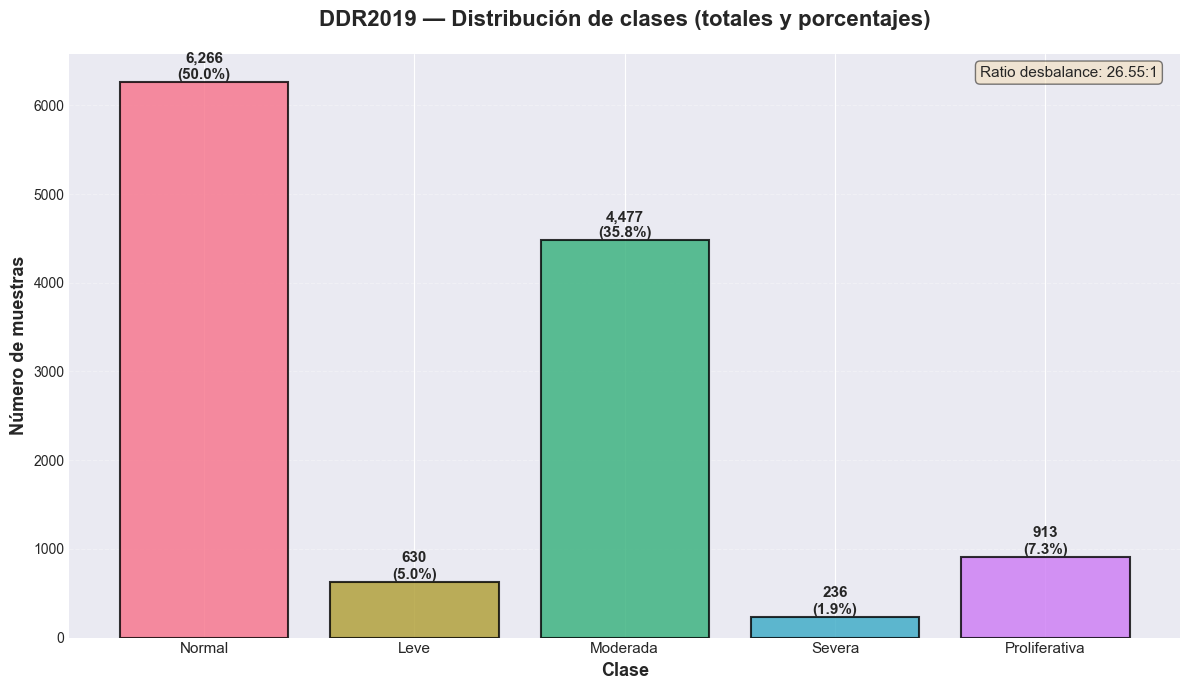

In [6]:
# Gráfica de distribución de clases con nombres, totales y porcentajes
LABEL_ES = {0: "Normal", 1: "Leve", 2: "Moderada", 3: "Severa", 4: "Proliferativa"}
labels_es = [LABEL_ES[int(k)] for k in class_counts.index]
x = np.arange(len(class_counts))

fig, ax = plt.subplots(figsize=(12, 7))
bars = ax.bar(x, class_counts.values, color=sns.color_palette("husl", len(class_counts)),
              edgecolor="black", linewidth=1.5, alpha=0.8)
plt.xticks(ticks=x, labels=labels_es, fontsize=11)
ax.set_xlabel("Clase", fontsize=13, fontweight="bold")
ax.set_ylabel("Número de muestras", fontsize=13, fontweight="bold")
ax.set_title("DDR2019 — Distribución de clases (totales y porcentajes)", fontsize=16, fontweight="bold", pad=20)
ax.grid(axis="y", alpha=0.3, linestyle="--")

for bar, count, pct in zip(bars, class_counts.values, class_percentages.values):
    ax.text(bar.get_x() + bar.get_width() / 2.0, bar.get_height(),
            f"{int(count):,}\n({pct:.1f}%)", ha="center", va="bottom", fontsize=11, fontweight="bold")

ax.text(0.98, 0.98, f"Ratio desbalance: {imbalance_ratio:.2f}:1", transform=ax.transAxes, fontsize=11,
        verticalalignment="top", horizontalalignment="right",
        bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5))
plt.tight_layout()
plt.show()

## Resumen estadístico por clase

La siguiente tabla muestra, desde una vista comparativa, la distribución de muestras por clase en el dataset, incluyendo su cantidad absoluta, el porcentaje que representan respecto al total y su tamaño relativo en comparación con la clase más frecuente. Esta información permite identificar de forma clara la dominancia de ciertas clases y el grado de subrepresentación de otras. Este resumen facilita la comprensión del peso relativo de cada clase dentro del conjunto de datos y proporciona una base descriptiva para analizar el impacto del desbalance en el comportamiento esperado del dataset.


In [7]:
# Tabla resumen por clase (cantidad, porcentaje, ratio respecto a la clase mayoritaria)
summary_data = {
    "Clase": [f"Clase {i}" for i in sorted(df["label"].unique())],
    "Cantidad": [class_counts[i] for i in sorted(df["label"].unique())],
    "Porcentaje": [f"{class_percentages[i]:.2f}%" for i in sorted(df["label"].unique())],
    "Ratio respecto al máx.": [
        f"{(class_counts[i] / max_class_count * 100):.1f}%"
        for i in sorted(df["label"].unique())
    ],
}
summary_df = pd.DataFrame(summary_data)
print("Resumen estadístico:")
print("=" * 60)
print(summary_df.to_string(index=False))
print("=" * 60)

Resumen estadístico:
  Clase  Cantidad Porcentaje Ratio respecto al máx.
Clase 0      6266     50.04%                 100.0%
Clase 1       630      5.03%                  10.1%
Clase 2      4477     35.75%                  71.4%
Clase 3       236      1.88%                   3.8%
Clase 4       913      7.29%                  14.6%


## Hallazgos principales y consideraciones derivadas del EDA

1. **Muestras totales**: El dataset contiene imágenes procesadas con sus etiquetas.
2. **Desbalance**: Existe un desbalance notable entre clases (ratio max/min alto).
3. **Clases minoritarias**: Las clases con pocos ejemplos se benefician de aumento de datos y/o ponderación de pérdida.
4. **Recomendaciones**:
   - Usar pesos de clase durante el entrenamiento.
   - Mantener muestreo estratificado en train/val/test.
   - Aplicar aumento de datos sobre todo en clases minoritarias.
   - Evaluar métricas por clase (precision/recall por clase).


# A continuación se analizan outliers en las imágenes (brillo, contraste) y recomendaciones de preprocesado y aumento de datos.

## Análisis de outliers en las imágenes (brillo y contraste)

Para clasificación de imágenes es útil detectar outliers en las propias imágenes: ejemplos con brillo o contraste extremos que pueden afectar al entrenamiento. Aquí calculamos, sobre una muestra de imágenes, el brillo medio (intensidad promedio en escala de grises) y el contraste (desviación típica de los píxeles). Con eso identificamos imágenes muy oscuras, muy claras o con contraste atípico.

In [8]:
# Calcular brillo, contraste y desenfoque (Laplacian variance) por imagen muestra
from PIL import Image
import cv2

SAMPLE_SIZE = 1500
np.random.seed(42)
sample_idx = np.random.choice(len(df), size=min(SAMPLE_SIZE, len(df)), replace=False)
sample_df = df.iloc[sample_idx].reset_index(drop=True)

brightness_list = []
contrast_list = []
blur_list = []
filenames_sample = []
labels_sample = []

images_dir = DATA_DIR / "images"

# Iteramos sobre la muestra de imágenes para calcular brillo, contraste y desenfoque
for _, row in sample_df.iterrows():
    fp = images_dir / row["filename"]
    if not fp.exists():
        continue
    try:
        # Cargamos la imagen en escala de grises
        img = np.array(Image.open(fp).convert("L"))

        # Calculamos el brillo (intensidad promedio)
        brightness_list.append(float(np.mean(img)))

        # Calculamos el contraste (desviación típica)
        contrast_list.append(float(np.std(img)))
        
        # Calculamos la varianza del Laplaciano para el desenfoque
        try:
            blur_var = float(cv2.Laplacian(img, cv2.CV_64F).var())
            if not np.isfinite(blur_var):
                blur_var = np.nan
        except Exception:
            blur_var = np.nan

        # Agregamos los resultados a las listas
        blur_list.append(blur_var)
        filenames_sample.append(row["filename"])
        labels_sample.append(int(row["label"]))
    except Exception:
        continue

brightness = np.array(brightness_list)
contrast = np.array(contrast_list)
blur = np.array(blur_list)

print(f"Imágenes procesadas: {len(brightness)}.")
print(f"Brillo: media={brightness.mean():.1f}, std={brightness.std():.1f}, mín={brightness.min():.1f}, máx={brightness.max():.1f}")
print(f"Contraste: media={contrast.mean():.1f}, std={contrast.std():.1f}, mín={contrast.min():.1f}, máx={contrast.max():.1f}")

blur_finite = blur[np.isfinite(blur)]
if len(blur_finite) > 0:
    # Se imprime el desenfoque de la muestra
    print(f"Desenfoque (var. Laplaciano): media={np.nanmean(blur):.1f}, std={np.nanstd(blur):.1f}, mín={np.nanmin(blur):.1f}, máx={np.nanmax(blur):.1f}")
else:
    # En caso de que no se pueda calcular el desenfoque, se imprime un mensaje
    print("Desenfoque (var. Laplaciano): no se pudo calcular para ninguna imagen.")

Imágenes procesadas: 1500.
Brillo: media=68.9, std=25.6, mín=3.2, máx=148.4
Contraste: media=47.1, std=15.8, mín=7.1, máx=91.2
Desenfoque (var. Laplaciano): no se pudo calcular para ninguna imagen.


Los resultados del análisis de outliers en brillo y contraste indican una variabilidad considerable en las condiciones de iluminación de las imágenes procesadas. En el caso del brillo, el amplio rango entre los valores mínimo y máximo, junto con una desviación estándar elevada respecto a la media, sugiere la presencia de imágenes muy oscuras y otras significativamente más iluminadas que el promedio. De forma similar, las métricas de contraste muestran una dispersión notable, lo que apunta a diferencias marcadas en la calidad visual y en la definición de estructuras entre imágenes.

Esta variabilidad refleja heterogeneidad en las condiciones de adquisición del dataset y no necesariamente la presencia de valores atípicos aislados, sino un rango amplio de escenarios visuales.

La incapacidad para determinar la métrica de desenfoque basada en la varianza del Laplaciano para las imágenes examinadas podría indicar que no disponemos de imágenes con un desenfoque significativo en el dataset.

### Visualización: brillo vs contraste para el análisis de outliers.

La gráfica muestra de forma conjunta la distribución del brillo y el contraste en la muestra analizada, así como la relación entre ambas variables. Los histogramas marginales indican que tanto el brillo como el contraste presentan distribuciones aproximadamente unimodales, con la mayor concentración de imágenes alrededor de valores intermedios y colas que reflejan casos más extremos, aunque poco frecuentes.

El diagrama de dispersión evidencia una relación positiva clara entre brillo y contraste. Conforme aumenta el brillo, el contraste tiende también a incrementarse. Esto sugiere que las variaciones en las condiciones de iluminación afectan simultáneamente a ambas propiedades visuales.

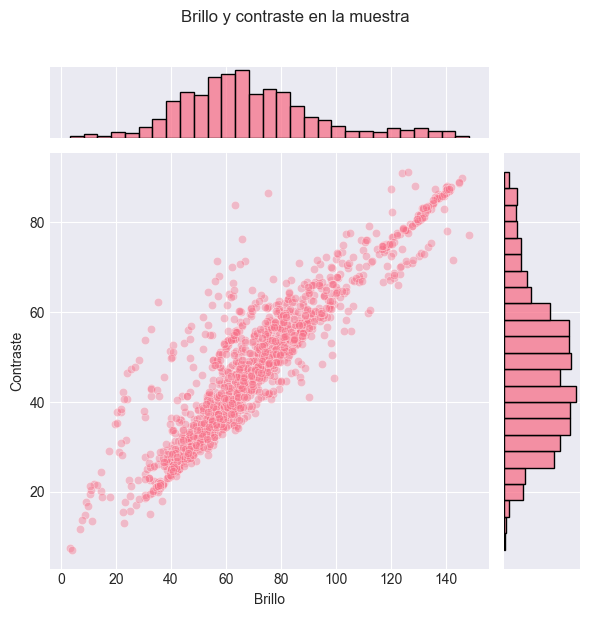

In [9]:
plot_df = pd.DataFrame({"Brillo": brightness, "Contraste": contrast})
g = sns.jointplot(data=plot_df, x="Brillo", y="Contraste", kind="scatter", alpha=0.4, height=6)
g.fig.suptitle("Brillo y contraste en la muestra", y=1.02)
plt.tight_layout()
plt.show()

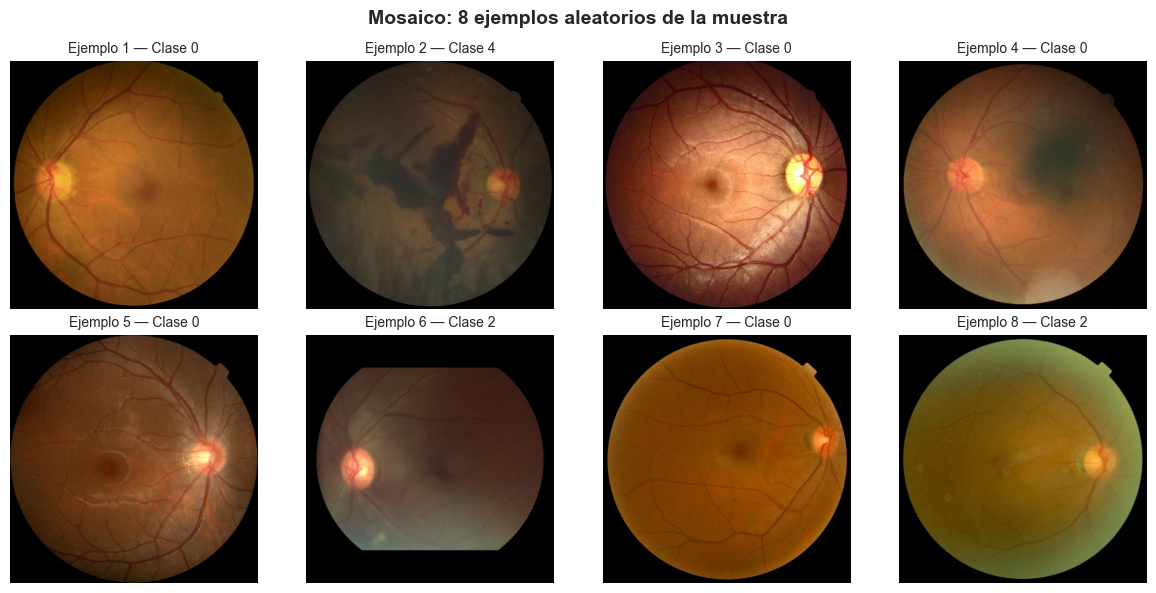

In [10]:
# Mosaico con 8 ejemplos aleatorios de la muestra (binning)
n_show = 8
rng = np.random.default_rng(42)
idx_mosaic = rng.choice(len(filenames_sample), size=min(n_show, len(filenames_sample)), replace=False)

fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.flatten()
for i, ax in enumerate(axes):
    if i < len(idx_mosaic):
        j = idx_mosaic[i]
        fp = images_dir / filenames_sample[j]
        img = np.array(Image.open(fp).convert("RGB"))
        ax.imshow(img)
        ax.set_title(f"Ejemplo {i + 1} — Clase {labels_sample[j]}", fontsize=10)
    ax.axis("off")
plt.suptitle("Mosaico: 8 ejemplos aleatorios de la muestra", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

Los resultados indican la presencia de un número limitado de outliers, principalmente asociados a la métrica de brillo. El método basado en el rango intercuartílico (IQR) identifica 76 imágenes con valores de brillo fuera de los límites definidos, mientras que el contraste presenta muy pocos casos atípicos. Únicamente el 5.1% de las imágenes contiene al menos un outlier, lo que sugiere que, aunque existen imágenes con condiciones de iluminación extremas, estas representan una fracción reducida del dataset y no dominan la distribución general.

Las gráficas que incluimos ayudan a visualizar estos outliers desde 2 perspectivas distintas.

In [11]:
# Detección de outliers por IQR (brillo y contraste)
def iqr_outliers(x, k=1.5):
    q1, q3 = np.percentile(x, [25, 75])
    iqr = q3 - q1
    low, high = q1 - k * iqr, q3 + k * iqr
    return np.where((x < low) | (x > high))[0], low, high

out_bright, br_low, br_high = iqr_outliers(brightness)
out_contrast, co_low, co_high = iqr_outliers(contrast)
out_any = np.unique(np.concatenate([out_bright, out_contrast]))

print(f"Outliers de brillo (IQR): {len(out_bright)} (límites: {br_low:.1f} - {br_high:.1f})")
print(f"Outliers de contraste (IQR): {len(out_contrast)} (límites: {co_low:.1f} - {co_high:.1f})")
print(f"Imágenes con al menos un outlier: {len(out_any)} ({100 * len(out_any) / len(brightness):.1f}%)")

Outliers de brillo (IQR): 76 (límites: 8.5 - 125.0)
Outliers de contraste (IQR): 3 (límites: 2.5 - 89.4)
Imágenes con al menos un outlier: 77 (5.1%)


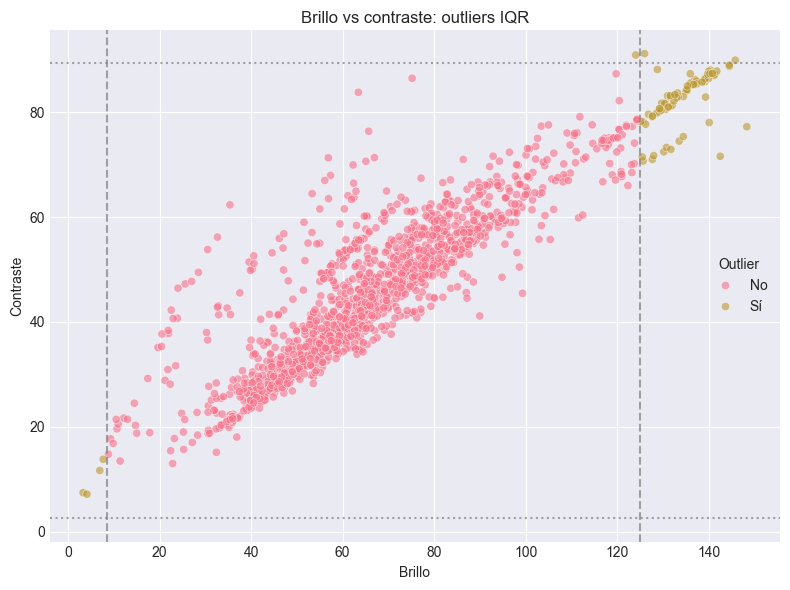

In [12]:
# Gráfico: brillo vs contraste con outliers resaltados (IQR)
df_iqr = pd.DataFrame({
    "Brillo": brightness,
    "Contraste": contrast,
    "Outlier": np.isin(np.arange(len(brightness)), out_any),
})
df_iqr["Outlier"] = df_iqr["Outlier"].map({True: "Sí", False: "No"})

fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(data=df_iqr, x="Brillo", y="Contraste", hue="Outlier", alpha=0.6, ax=ax)
ax.axvline(br_low, color="gray", linestyle="--", alpha=0.7)
ax.axvline(br_high, color="gray", linestyle="--", alpha=0.7)
ax.axhline(co_low, color="gray", linestyle=":", alpha=0.7)
ax.axhline(co_high, color="gray", linestyle=":", alpha=0.7)
ax.set_title("Brillo vs contraste: outliers IQR")

plt.tight_layout()
plt.show()

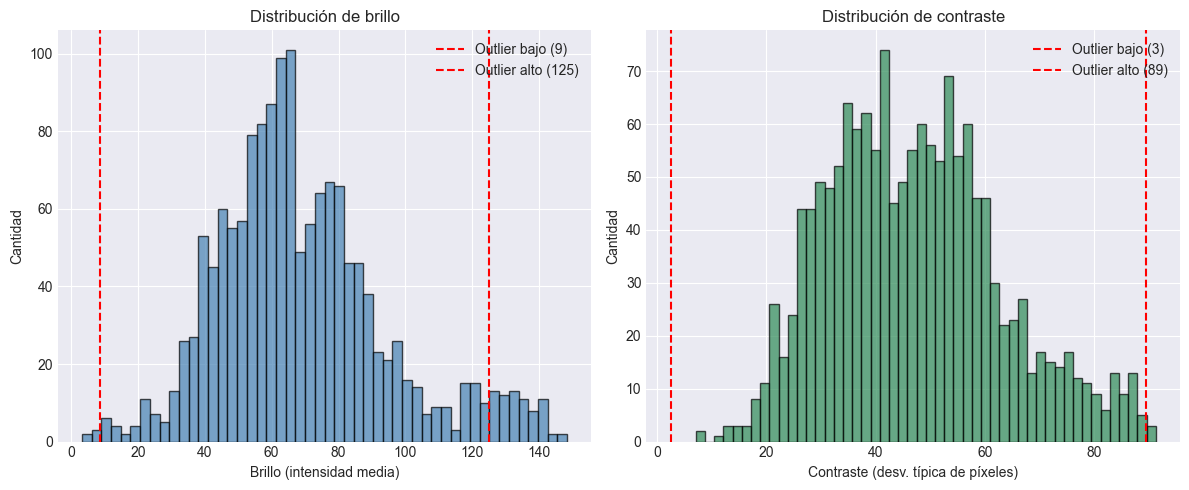

In [13]:
# Visualización: distribución de brillo y contraste
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].hist(brightness, bins=50, color="steelblue", edgecolor="black", alpha=0.7)
axes[0].axvline(br_low, color="red", linestyle="--", label=f"Outlier bajo ({br_low:.0f})")
axes[0].axvline(br_high, color="red", linestyle="--", label=f"Outlier alto ({br_high:.0f})")
axes[0].set_xlabel("Brillo (intensidad media)")
axes[0].set_ylabel("Cantidad")
axes[0].set_title("Distribución de brillo")
axes[0].legend()

axes[1].hist(contrast, bins=50, color="seagreen", edgecolor="black", alpha=0.7)
axes[1].axvline(co_low, color="red", linestyle="--", label=f"Outlier bajo ({co_low:.0f})")
axes[1].axvline(co_high, color="red", linestyle="--", label=f"Outlier alto ({co_high:.0f})")
axes[1].set_xlabel("Contraste (desv. típica de píxeles)")
axes[1].set_ylabel("Cantidad")
axes[1].set_title("Distribución de contraste")
axes[1].legend()

plt.tight_layout()
plt.show()

## Recomendaciones de aumento de datos (data augmentation)

Dado el desbalance y las clases minoritarias, conviene aplicar data segmentation sobre todo en las clases con menos ejemplos. Para minimizar el riesgo de perjudicar la predicción, se recomienda usar los métodos Flip y rotaciones, los cuales son las transformaciones con menor riesgo de dañar el rendimiento del modelo.

### Recomendación del proyecto:
- Data augmentation: usar Flip (horizontal/vertical) y rotaciones (p. ej. más o menos 15–30°). Otras transformaciones (brillo/contraste, ruido) pueden alterar más la señal y no se recomiendan como estándar.
- A continuación se listan las transformaciones concretas sugeridas para el pipeline de entrenamiento (Usando PyTorch):
  - RandomHorizontalFlip(p=0.5)
  - RandomVerticalFlip(p=0.5)
  - RandomRotation(degrees=15)
  - Clases minoritarias a priorizar para aumento de datos: [1, 3, 4]

## Gráfico de distribución de brillo con percentiles y umbrales

La siguiente gráfica muestra la distribución del brillo medio de las imágenes, junto con percentiles clave y umbrales de referencia para identificar condiciones extremas de iluminación. Se observa que la mayor concentración de muestras se sitúa alrededor del percentil 50, indicando un nivel de brillo intermedio dominante en el dataset, mientras que los percentiles 5 y 95 delimitan un rango amplio que refleja la variabilidad en las condiciones de adquisición. Los umbrales definidos para imágenes oscuras y claras permiten contextualizar visualmente qué proporción del dataset se encuentra cerca de condiciones de iluminación potencialmente problemáticas, mostrando desde otro ángulo que los casos extremos existen, pero representan una fracción minoritaria frente al conjunto total de imágenes.

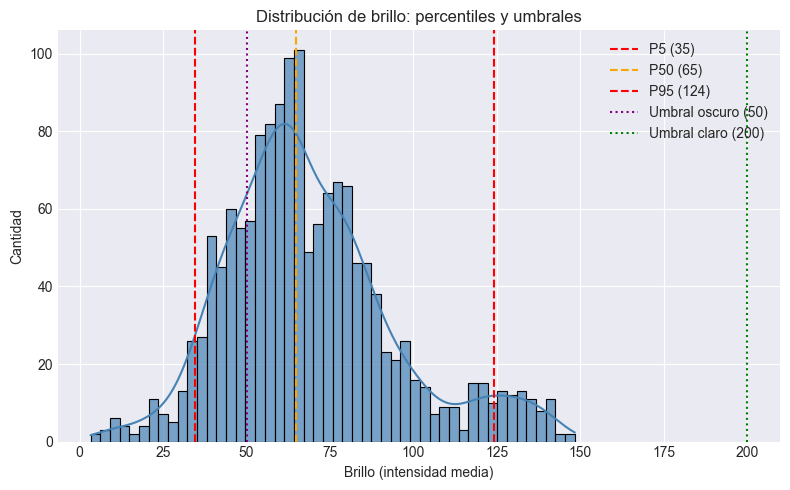

In [14]:
p5, p50, p95 = np.percentile(brightness, [5, 50, 95])

fig, ax = plt.subplots(figsize=(8, 5))
sns.histplot(brightness, bins=50, kde=True, color="steelblue", ax=ax, edgecolor="black", alpha=0.7)

ax.axvline(p5, color="red", linestyle="--", label=f"P5 ({p5:.0f})")
ax.axvline(p50, color="orange", linestyle="--", label=f"P50 ({p50:.0f})")
ax.axvline(p95, color="red", linestyle="--", label=f"P95 ({p95:.0f})")
ax.axvline(50, color="purple", linestyle=":", label="Umbral oscuro (50)")
ax.axvline(200, color="green", linestyle=":", label="Umbral claro (200)")
ax.set_xlabel("Brillo (intensidad media)")
ax.set_ylabel("Cantidad")
ax.set_title("Distribución de brillo: percentiles y umbrales")
ax.legend()

plt.tight_layout()
plt.show()

## Preprocesado: filtros e imágenes muy oscuras o muy claras

Para el filtro de preprocesado se recomienda usar el método CLAHE (Contrast-Limited Adaptive Histogram Equalization). El cual mejora el contraste local en imágenes, con bajo riesgo de perjudicar la predicción. En el proyecto ya tenemos implementado el uso de este método desde la librería de OpenCV. Algo que compartiremos en futuras entregas.

Si además el análisis de brillo muestra muchas imágenes muy oscuras o muy claras, puede combinarse con normalización por imagen o recorte por percentiles. A continuación se resume la distribución de brillo.

In [15]:
# Resumen de brillo y recomendaciones de preprocesado
p5, p50, p95 = np.percentile(brightness, [5, 50, 95])
print("Percentiles de brillo (muestra):")
print(f"  5%: {p5:.1f}  50%: {p50:.1f}  95%: {p95:.1f}")

# Criterios simples: muy oscuro < 50, muy claro > 200 (escala 0-255)
dark = np.sum(brightness < 50)
bright = np.sum(brightness > 200)
print(f"\nImágenes con brillo medio < 50 (muy oscuras): {dark} ({100 * dark / len(brightness):.1f}%)")
print(f"Imágenes con brillo medio > 200 (muy claras): {bright} ({100 * bright / len(brightness):.1f}%)")

if dark > 0.05 * len(brightness) or bright > 0.05 * len(brightness):
    print("\nRecomendación: usar CLAHE como filtro de preprocesado. Opcionalmente añadir normalización por imagen.")
else:
    print("\nRecomendación: CLAHE sigue siendo el filtro recomendado; la normalización estándar (media/std) puede bastar.")

Percentiles de brillo (muestra):
  5%: 34.7  50%: 64.7  95%: 124.1

Imágenes con brillo medio < 50 (muy oscuras): 327 (21.8%)
Imágenes con brillo medio > 200 (muy claras): 0 (0.0%)

Recomendación: usar CLAHE como filtro de preprocesado. Opcionalmente añadir normalización por imagen.


## Conclusiones del EDA para clasificación de imágenes DR

A partir del análisis exploratorio realizado, es posible sintetizar una serie de hallazgos relevantes sobre la estructura del dataset, la distribución de las clases y la calidad visual de las imágenes. Estas conclusiones no buscan adelantar decisiones de modelado, sino resumir las características observadas durante el EDA y contextualizar las respuestas a las preguntas planteadas, estableciendo una base para las etapas posteriores del proyecto.

1. **Balance**: El dataset presenta un desbalance significativo entre clases, lo que sugiere que las clases minoritarias podrían beneficiarse de estrategias como la ponderación de la función de pérdida y el aumento de datos.
2. **Outliers**: El análisis de brillo y contraste en una muestra de imágenes permite identificar casos visualmente atípicos; aunque no dominan el dataset, estos deben considerarse en el diseño del preprocesamiento.
3. **Data augmentation**: Técnicas como **flips y rotaciones** se perfilan como opciones adecuadas, al ser transformaciones de bajo riesgo que pueden aplicarse priorizando las clases minoritarias.
4. **Preprocesado / filtros**: El uso de **CLAHE** se presenta como una alternativa razonable para mejorar el contraste local y mitigar variaciones de iluminación observadas durante el EDA.
 
_________________________________________________________________________________________________________________________________

1. **¿Hay valores faltantes en el conjunto de datos? ¿Se pueden identificar patrones de ausencia?** 

    No se identifican valores faltantes en el conjunto de datos. El archivo CSV contiene únicamente dos columnas (filename y label), ambas completas para todas las observaciones. En consecuencia, no se detectan patrones de ausencia que requieran procesos de imputación o limpieza adicional.

2. **¿Cuáles son las estadísticas resumidas del conjunto de datos?**

    El análisis exploratorio indica que el dataset está compuesto por 5 clases (0 a 4), correspondientes a distintos niveles de severidad de la retinopatía diabética. La distribución de imágenes entre clases no es uniforme, observándose una clara disparidad en el número de ejemplos, particularmente en las clases de mayor severidad. Estas estadísticas confirman que se trata de un problema de clasificación multiclase con un desbalance marcado entre categorías.

3. **¿Hay valores atípicos en el conjunto de datos?**

   Sí, se identifican imágenes atípicas desde una perspectiva visual, principalmente asociadas a variaciones extremas de brillo y contraste, así como a diferencias en la calidad de adquisición. Estos outliers no corresponden a errores en los datos, sino a características propias del dominio médico, por lo que no se consideran candidatos a eliminación, aunque sí deben tenerse en cuenta durante el preprocesamiento.

4. **¿Cuál es la cardinalidad de las variables categóricas?**

    La única variable categórica del conjunto de datos es `label`, cuya cardinalidad es 5, correspondiente a los niveles de severidad 0, 1, 2, 3 y 4. No se identifican otras variables categóricas en el dataset.

5. **¿Existen distribuciones sesgadas en el conjunto de datos? ¿Necesitamos aplicar alguna transformación no lineal?**

    Sí, la distribución de las clases se encuentra fuertemente sesgada hacia los niveles de menor severidad, en particular la clase 0. Dado que se trata de un conjunto de imágenes, no se aplican transformaciones no lineales clásicas propias de datos tabulares. No obstante, el EDA sugiere la conveniencia de aplicar transformaciones específicas de imagen, como normalización de intensidades, ajustes de contraste y técnicas de ecualización cuando sea necesario.

6. **¿Se identifican tendencias temporales? (En caso de que el conjunto incluya una dimensión de tiempo).**
    
    No se identifican tendencias temporales, ya que el conjunto de datos no incluye una dimensión asociada al tiempo.

7. **¿Hay correlación entre las variables dependientes e independientes?**

    Al tratarse de un problema de clasificación de imágenes, la variable dependiente es label y las variables independientes corresponden a los píxeles de las imágenes. En este contexto, no se realiza un análisis de correlación clásica (por ejemplo, Pearson o Spearman), ya que no resulta directamente aplicable.

8. **¿Cómo se distribuyen los datos en función de diferentes categorías? (análisis bivariado)**

    El análisis bivariado entre la clase (label) y el número de imágenes muestra que las clases de menor severidad concentran la mayor parte de los ejemplos, mientras que las clases más severas (3 y 4) están subrepresentadas. Esta distribución tiene implicaciones directas en el entrenamiento del modelo, al introducir un sesgo potencial hacia las clases mayoritarias.

9. **¿Se deberían normalizar las imágenes para visualizarlas mejor?**

    Sí, se considera altamente recomendable normalizar las imágenes. El EDA evidencia variaciones importantes en las condiciones de iluminación, por lo que se sugiere la normalización de los valores de píxel (por ejemplo, al rango [0,1]), así como posibles ajustes de contraste que faciliten tanto la visualización como el aprendizaje de características relevantes durante el entrenamiento del modelo.

10. **¿Hay desequilibrio en las clases de la variable objetivo?**

    Sí, existe un fuerte desequilibrio en las clases de la variable objetivo. El análisis confirma que las clases mayoritarias dominan el dataset, mientras que las clases minoritarias requieren estrategias adicionales, como aumento de datos, ponderación de clases en la función de pérdida y el uso de métricas más robustas que la exactitud, como F1-score o recall por clase.


Referencias

- Kumar Mukhiya, S., y Ahmed, U. (2020). Hands-On Exploratory Data Analysis with Python. Packt Publishing.
- Visengeriyeva, L., Kammer, A., Bär, I., Kniesz, A., y Plöd, M. (2023). CRISP-ML(Q). The ML Lifecycle Process. MLOps. INNOQ. 